Found 557 images belonging to 2 classes.
Found 140 images belonging to 2 classes.
Found 140 images belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 861ms/step - accuracy: 0.6857 - loss: 0.5796

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.6928 - loss: 0.5685 - val_accuracy: 0.9286 - val_loss: 0.1503 - learning_rate: 0.0010
Epoch 2/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate
  current = self.get_monitor_value(logs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9419 - loss: 0.1311 - val_accuracy: 0.9357 - val_loss: 0.1165 - learning_rate: 0.0010
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9513 - loss: 0.1435 - val_accuracy: 0.8929 - val_loss: 0.2497 - learning_rate: 0.0010
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9349 - loss: 0.1420 - val_accuracy: 0.9286 - val_loss: 0.1628 - learning_rate: 0.0010
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 9/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9506 - loss: 0.1123 - val

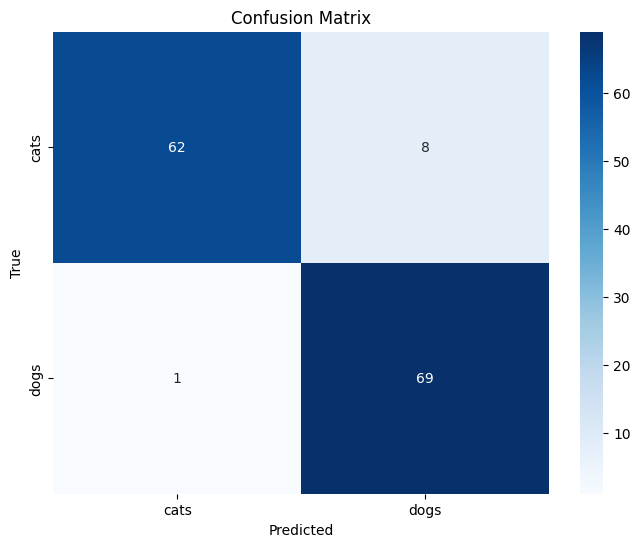

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard

# --- Data Preparation ---
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/cats-and-dogs-image-classification/train', target_size=(224, 224), batch_size=32, class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    '/kaggle/input/cats-and-dogs-image-classification/test', target_size=(224, 224), batch_size=32, class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/cats-and-dogs-image-classification/test', target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False
)

# --- Model Architecture ---
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the pre-trained model

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)  # Dropout to reduce overfitting
output = Dense(1, activation='sigmoid')(x)  # Binary classification

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# --- Callbacks ---
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)

# --- Training ---
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[lr_scheduler, early_stopping, tensorboard_callback],
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

# --- Fine-tuning ---
# Unfreeze some layers of the base model
base_model.trainable = True

# Recompile with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune the model
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[lr_scheduler, early_stopping, tensorboard_callback],
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

# --- Evaluation ---
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# --- Confusion Matrix ---
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on test data
predictions = (model.predict(test_generator) > 0.5).astype("int32")
true_labels = test_generator.classes

# Confusion matrix
cm = confusion_matrix(true_labels, predictions)
print(classification_report(true_labels, predictions))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted: Dog (92.55%)


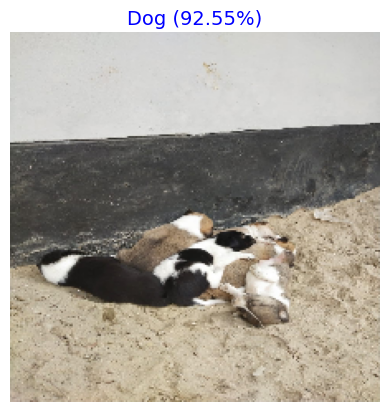

In [9]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model



# Update the image size to match the model input
IMG_SIZE = (224, 224)  # Ensure this matches the model's expected input size

def predict_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)  # Resize image to (224,224)
    img_array = image.img_to_array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions for batch processing

    # Make a prediction
    prediction = model.predict(img_array)

    # Interpret the result
    if prediction[0] > 0.5:
        print(f"Predicted: Dog ({prediction[0][0]*100:.2f}%)")
    else:
        print(f"Predicted: Cat ({(1-prediction[0][0])*100:.2f}%)")

 # Display the image with prediction

    if prediction[0] > 0.5:
        label = f"Dog ({prediction[0][0]*100:.2f}%)"
    else:
        label = f"Cat ({(1-prediction[0][0])*100:.2f}%)"
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.title(label, fontsize=14, color='blue')  # Display prediction
    plt.show()


# Test with your own image
predict_image('/kaggle/input/dog-and-cat/WhatsApp Image 2025-01-31 at 15.47.36 (1).jpeg')  # Replace with your image path



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


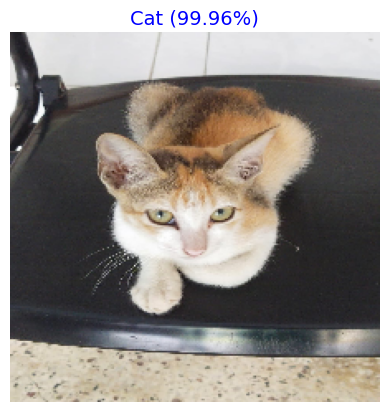

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model



# Update the image size to match the model input
IMG_SIZE = (224, 224)  # Ensure this matches the model's expected input size

def predict_image(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=IMG_SIZE)  # Resize image
    img_array = image.img_to_array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions for batch processing

    # Make a prediction
    prediction = model.predict(img_array)

    # Interpret the result
    if prediction[0] > 0.5:
        label = f"Dog ({prediction[0][0]*100:.2f}%)"
    else:
        label = f"Cat ({(1-prediction[0][0])*100:.2f}%)"

    # Display the image with prediction
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.title(label, fontsize=14, color='blue')  # Display prediction
    plt.show()

# Test with your own image
predict_image('/kaggle/input/dog-and-cat/WhatsApp Image 2025-01-31 at 15.47.36.jpeg')  # Replace with your image path


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


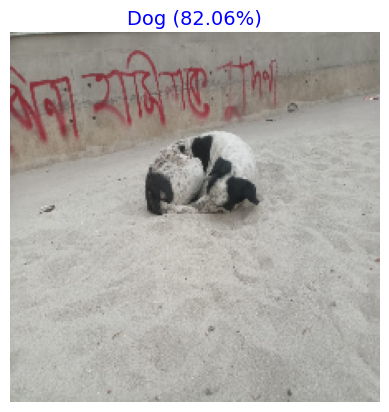

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


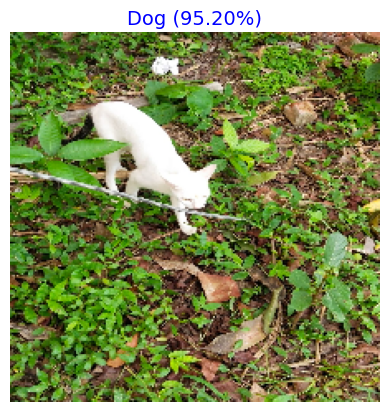

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


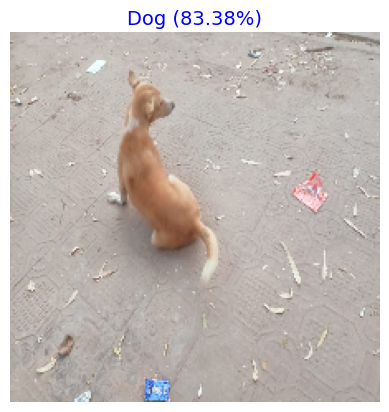

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


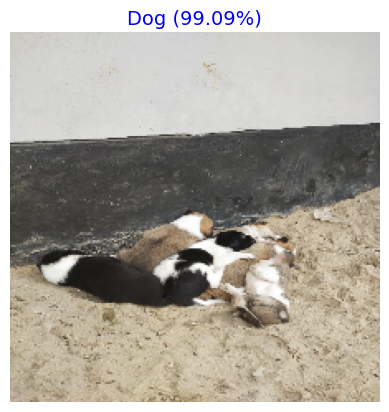

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


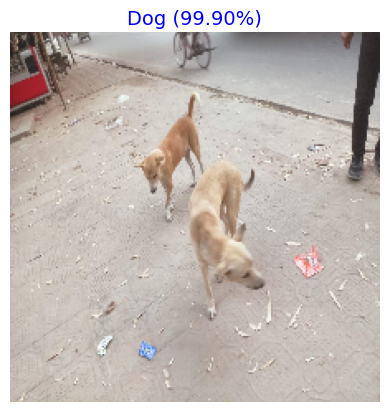

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


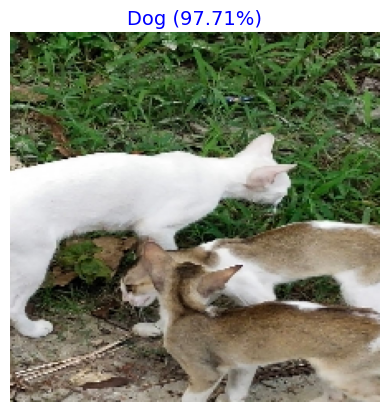

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


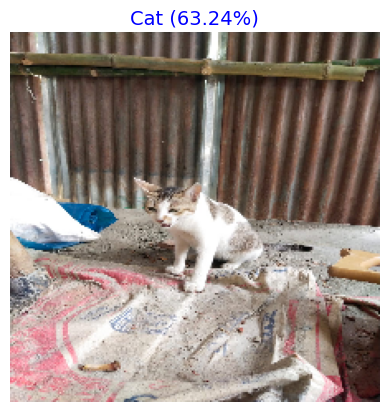

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


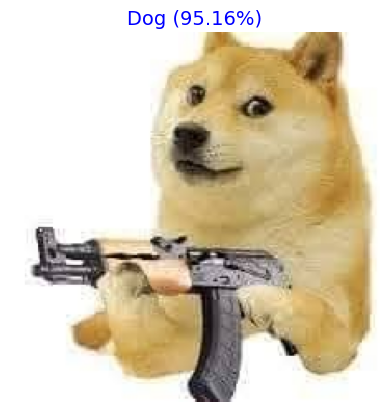

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


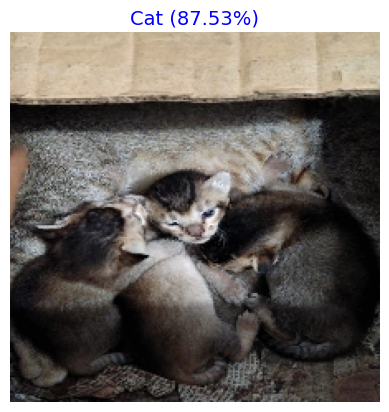

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


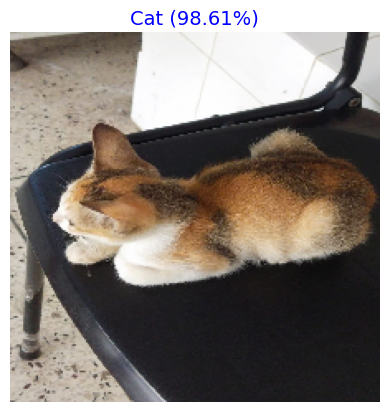

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


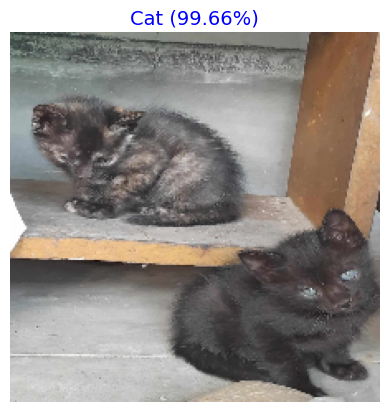

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


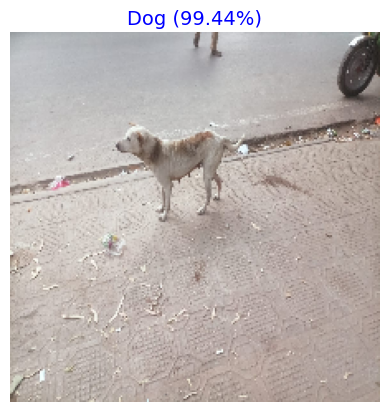

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


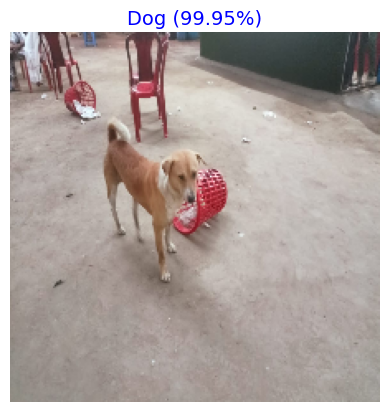

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


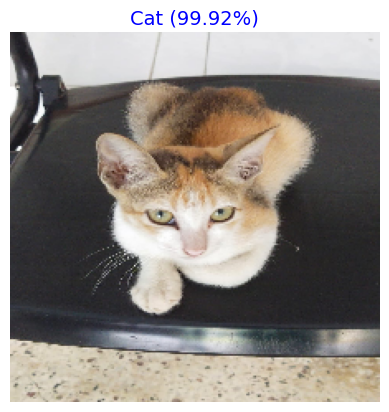

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


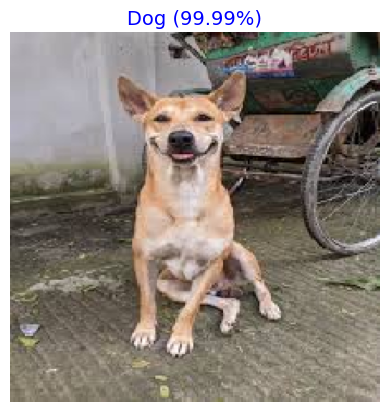

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


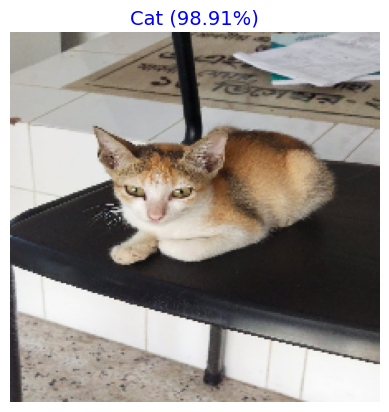

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model


# Define the path to your test images folder
test_images_folder = '/kaggle/input/allimages'  # Replace with your folder path

# Update the image size to match the model input
IMG_SIZE = (224, 224)  # Ensure this matches the model's expected input size

def predict_and_display_images(folder_path):
    # Get all image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

    # Loop through each image
    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)  # Get full image path
        
        # Load and preprocess the image
        img = image.load_img(img_path, target_size=IMG_SIZE)  # Resize image
        img_array = image.img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions for batch processing

        # Make a prediction
        prediction = model.predict(img_array)

        # Interpret the result
        if prediction[0] > 0.5:
            label = f"Dog ({prediction[0][0]*100:.2f}%)"
        else:
            label = f"Cat ({(1-prediction[0][0])*100:.2f}%)"

        # Display the image with prediction
        plt.figure()  # Create a new figure for each image
        plt.imshow(img)
        plt.axis('off')  # Hide axes
        plt.title(label, fontsize=14, color='blue')  # Display prediction
        plt.show()

# Run the function on your test images folder
predict_and_display_images(test_images_folder)
